In [1]:
import sys
sys.path.insert(0, '../')

import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from PIL import Image, UnidentifiedImageError
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import torch
import torchvision.models as models
import torch.nn as nn
from tqdm.auto import tqdm

from src.features import build_features

d:\Users\Julien\Documents\developpement\python\mai24_bds_extraction_info\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### single picture

In [166]:
#selecting a random picture
import os
import random

path = './../data/raw/selected'
pics = [f for f in os.listdir(path) if f.endswith('.tif')]
pic = random.choice(pics)
label = pic[:-4] + '.txt'



In [167]:
print('Selected picture:', pic)
print('Selected label:', label)

Selected picture: 50521440-1441.tif
Selected label: 50521440-1441.txt


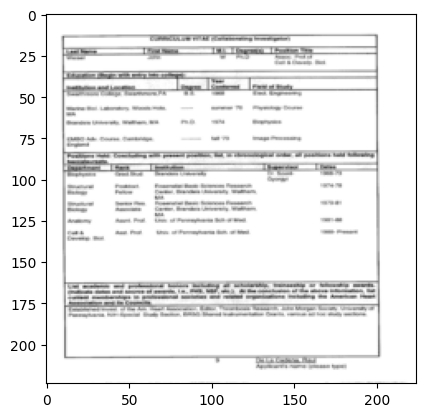

14


In [168]:
#cnn preprocessing
processed_images = build_features.cnn_process_image(path + '/' + pic)
cnn_pic = processed_images[2]

#plot the image
image = cnn_pic.clone().detach()
image = image.squeeze(0)
image = image.permute(1, 2, 0)
image = image.numpy()
plt.imshow(image)
plt.show()


#print the label
with open(path + '/' + label) as f:
    real_label = f.read()
    print(real_label)




In [169]:
#loading the cnn model
cnn_model = models.efficientnet_b0()
cnn_model.classifier[1] = nn.Linear(cnn_model.classifier[1].in_features, 16)
cnn_model.load_state_dict(torch.load('./../models/cnn_model.pth'))

<All keys matched successfully>

In [170]:
#making a random prediction with the loaded model
cnn_model.eval()
cnn_output = cnn_model(cnn_pic)
cnn_output = nn.functional.softmax(cnn_output, dim=1)
cnn_output[0]

tensor([1.8948e-04, 4.0744e-01, 2.6596e-03, 1.1821e-04, 1.4604e-02, 1.0710e-02,
        1.9709e-02, 1.9122e-01, 2.3786e-05, 3.7356e-04, 2.5125e-05, 4.2294e-03,
        6.5400e-05, 1.5756e-03, 3.4694e-01, 1.1687e-04],
       grad_fn=<SelectBackward0>)

In [171]:
#printing the prediction
print('CNN prediction:', cnn_output.argmax().item())
print('Real label:', real_label)

CNN prediction: 1
Real label: 14


In [172]:
#nlp preprocessing
with Image.open(path + '/' + pic) as img:
            nlp_pic = np.array(img)
nlp_pic = Image.fromarray(nlp_pic)
nlp_pic = nlp_pic.resize((1000, 1000))
nlp_pic = np.array(nlp_pic)
nlp_text = build_features.ocr_pytesseract(nlp_pic)
nlp_text = build_features.text_cleaning(nlp_text)



In [173]:
#loading the nlp model
with open('./../models/nlp_model.pkl', 'rb') as file:
    nlp_model = pickle.load(file)

In [174]:
#making a random prediction with the loaded model
nlp_output = nlp_model.predict_proba([nlp_text])
nlp_output

array([[1.87468606e-03, 1.40558430e-03, 1.02417402e-03, 5.11780237e-04,
        5.76449204e-04, 2.24041571e-03, 1.52628840e-03, 7.38099472e-04,
        6.61889034e-04, 1.13107361e-03, 1.11435840e-03, 1.09256143e-03,
        1.68028939e-03, 9.80554706e-04, 9.82107432e-01, 1.33436422e-03]])

In [175]:
#printing the prediction
print('NLP prediction:', nlp_output.argmax())
print('Real label:', real_label)

NLP prediction: 14
Real label: 14


In [176]:
#adding the probability of the two models
cnn_output = cnn_output.detach().numpy()

output = cnn_output + nlp_output
prediction = np.argmax(output)
print('Real label', real_label)
print('CNN prediction:', cnn_output.argmax().item())
print('NLP prediction:', nlp_output.argmax())
print('Final prediction:', prediction)

print("#"*20)
print('CNN probability:', cnn_output[0][cnn_output.argmax().item()])
print('NLP probability:', nlp_output[0][nlp_output.argmax()])
print('Final probability:', output[0][prediction])

Real label 14
CNN prediction: 1
NLP prediction: 14
Final prediction: 14
####################
CNN probability: 0.40744382
NLP probability: 0.9821074318074582
Final probability: 1.3290473531865477


### test set

In [2]:
rvlcdip_test_path = "./../data/raw/selected_test"

#puting all the files, pictures and targets into a list
picture_list = []
target_list = []
file_list = []
for file in glob.glob(f"{rvlcdip_test_path}/*.tif"):
    try:
        with Image.open(file) as img:
            img_array = np.array(img) #save to a numpy array because there were too much files open otherwise.
            picture_list.append(img_array)

        target_file = file.replace(".tif", ".txt")
        with open(target_file, 'r', encoding='utf-8') as f:
            target = f.read()
            target_list.append(target)
            file_list.append(file.split('\\')[-1])
    except UnidentifiedImageError:
        print(f"Le fichier {file} n'a pas pu être ouvert.")
        continue

#stitching in a dataframe file name, picture and text
df = pd.DataFrame(columns=['filename', 'picture', 'target'])
df['filename'] = file_list
df['picture'] = picture_list
df['target'] = target_list
df['target'] = df['target'].astype(int)

In [2]:
#loading the cnn model
#cnn_model = models.efficientnet_b0()
#cnn_model.classifier[1] = nn.Linear(cnn_model.classifier[1].in_features, 16)
#cnn_model.load_state_dict(torch.load('./../models/cnn_model.pth'))

cnn_model = models.efficientnet_b1()
cnn_model.classifier[1] = nn.Linear(cnn_model.classifier[1].in_features, 16)
cnn_model.load_state_dict(torch.load('./../models/cnn_model_b1_V2.pth'))

<All keys matched successfully>

In [3]:
#loading the nlp model
with open('./../models/nlp_model.pkl', 'rb') as file:
    nlp_model = pickle.load(file)

In [6]:
#preprocessing CNN
df['cnn_processed_images'] = df['picture'].apply(build_features.cnn_process_image)

In [5]:
#preprocessing NLP
df['picture_resize'] = df.apply(lambda x: build_features.image_resize(x['picture']), axis=1)
df['ocr_text'] = build_features.pytesseract_ocr(df.picture_resize)
df['clean_text'] = build_features.clean_text(df.ocr_text)

100%|██████████| 4000/4000 [31:45<00:00,  2.10it/s]


Nombre de mots dans le vocabulaire avant suppression des moins frequents: 73644
Suppression des mots qui apparaissent moins de 2 fois.
Nombre de mots dans le vocabulaire apres suppression des moins frequents: 14168


In [10]:
#saving the dataframe
df.to_pickle('./../data/raw/df_voting.pkl')

In [4]:
#loading the dataframe
df = pd.read_pickle('./../data/raw/df_voting.pkl')

In [5]:
#predicting the target with the two models
predictions = []
results_df = pd.DataFrame(columns=['cnn_proba', 'nlp_proba'])

for index, row in tqdm(df.iterrows()):
    #CNN
    cnn_model.eval()
    cnn_output = cnn_model(row['cnn_processed_images'][2])
    cnn_output = nn.functional.softmax(cnn_output, dim=1)
    cnn_output = cnn_output.detach().numpy()[0]

    #NLP
    nlp_text = row['clean_text']
    nlp_output = nlp_model.predict_proba([nlp_text])

    results_df.loc[index] = [cnn_output, nlp_output[0]]

results_df['target'] = df['target']

results_df.head()

4000it [04:31, 14.73it/s]


,cnn_proba,nlp_proba,target
0,"[4.6528731e-07, 2.583241e-11, 1.2869286e-10, 5...","[0.10309111928112423, 0.014764455703316933, 0....",15
1,"[2.6267859e-08, 3.6732865e-05, 6.528103e-10, 1...","[0.011858164307574297, 0.02815433984789278, 0....",7
2,"[0.23280933, 2.308246e-06, 2.2423892e-08, 4.22...","[0.2979345116366532, 0.06196387137669672, 0.09...",15
3,"[1.6954743e-12, 7.591842e-11, 3.5626922e-19, 6...","[0.01388915347251988, 0.020234147051457468, 0....",10
4,"[1.2258863e-06, 9.270226e-08, 8.1098295e-10, 3...","[0.04271491618796478, 0.036062989595332606, 0....",9


In [33]:
results_df.cnn_proba[0]

array([9.7716926e-05, 4.1584184e-07, 4.3146189e-10, 2.1986615e-14,
       5.5901971e-08, 1.3457102e-07, 2.7733535e-10, 2.3009392e-08,
       7.9588766e-12, 3.2293639e-09, 1.2270627e-11, 1.1117354e-10,
       1.9557468e-10, 1.8792006e-12, 9.8811466e-09, 9.9990165e-01],
      dtype=float32)

In [6]:
results_df.cnn_proba[0]

array([4.6528731e-07, 2.5832411e-11, 1.2869286e-10, 5.5408013e-14,
       2.0304786e-13, 1.9575347e-11, 1.5936558e-13, 3.0924951e-15,
       7.4825545e-12, 8.8788751e-12, 1.6241911e-11, 1.5595779e-12,
       4.9883420e-10, 3.1736433e-11, 6.1643253e-11, 9.9999952e-01],
      dtype=float32)

In [7]:
#calculating the raw accuracy and f1 score for each models and voting
cnn_accuracy = accuracy_score(results_df['target'], results_df['cnn_proba'].apply(np.argmax))
nlp_accuracy = accuracy_score(results_df['target'], results_df['nlp_proba'].apply(np.argmax))
voting_accuracy = accuracy_score(results_df['target'], results_df.apply(lambda x: np.argmax(x['cnn_proba'] + x['nlp_proba']), axis=1))

cnn_f1 = f1_score(results_df['target'], results_df['cnn_proba'].apply(np.argmax), average='weighted')
nlp_f1 = f1_score(results_df['target'], results_df['nlp_proba'].apply(np.argmax), average='weighted')
voting_f1 = f1_score(results_df['target'], results_df.apply(lambda x: np.argmax(x['cnn_proba'] + x['nlp_proba']), axis=1), average='weighted')

print('CNN accuracy:', cnn_accuracy)
print('NLP accuracy:', nlp_accuracy)
print('Voting accuracy:', voting_accuracy)
print('CNN f1:', cnn_f1)
print('NLP f1:', nlp_f1)
print('Voting f1:', voting_f1)

CNN accuracy: 0.81925
NLP accuracy: 0.6795
Voting accuracy: 0.83375
CNN f1: 0.8196457286810892
NLP f1: 0.6884154247121642
Voting f1: 0.8341931470406941


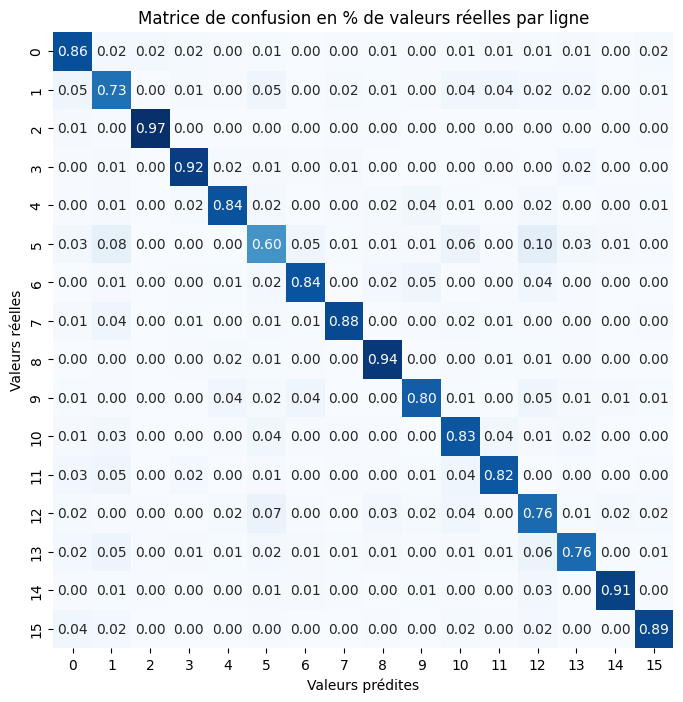

Accuracy: 0.83375
F1: 0.8341931470406941


In [8]:
#ploting the raw confusion matrix
y_test = results_df['target']
y_pred = results_df.apply(lambda x: np.argmax(x['cnn_proba'] + x['nlp_proba']), axis=1)
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', cbar=False)
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion en % de valeurs réelles par ligne')
plt.show()

#calculating the accuracy
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print('Accuracy:', accuracy)
print('F1:', f1)

In [9]:
#looping on a global ratio to find the best one
best_accuracy = 0
best_f1 = 0
best_ratio_acc = 0
best_ratio_f1 = 0
ratios = np.arange(0, 1.01, 0.01)

for ratio in tqdm(ratios):
    results_df['weighted_prob'] = results_df.apply(lambda row: ratio*row['cnn_proba'] + (1-ratio)*row['nlp_proba'], axis=1)
    results_df['predicted_class'] = np.argmax(np.array(results_df['weighted_prob'].tolist()), axis=1)
    accuracy = accuracy_score(df.target, results_df.predicted_class)
    f1 = f1_score(df.target, results_df.predicted_class, average='weighted')

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_ratio_acc = ratio

    if f1 > best_f1:
        best_f1 = f1
        best_ratio_f1 = ratio
    
print(f'Best accuracy: {best_accuracy} with ratio {best_ratio_acc}')
print(f'Best f1: {best_f1} with ratio {best_ratio_f1}')

100%|██████████| 101/101 [00:07<00:00, 14.02it/s]

Best accuracy: 0.84875 with ratio 0.31
Best f1: 0.8490174199608983 with ratio 0.31


100%|██████████| 101/101 [00:07<00:00, 14.19it/s]


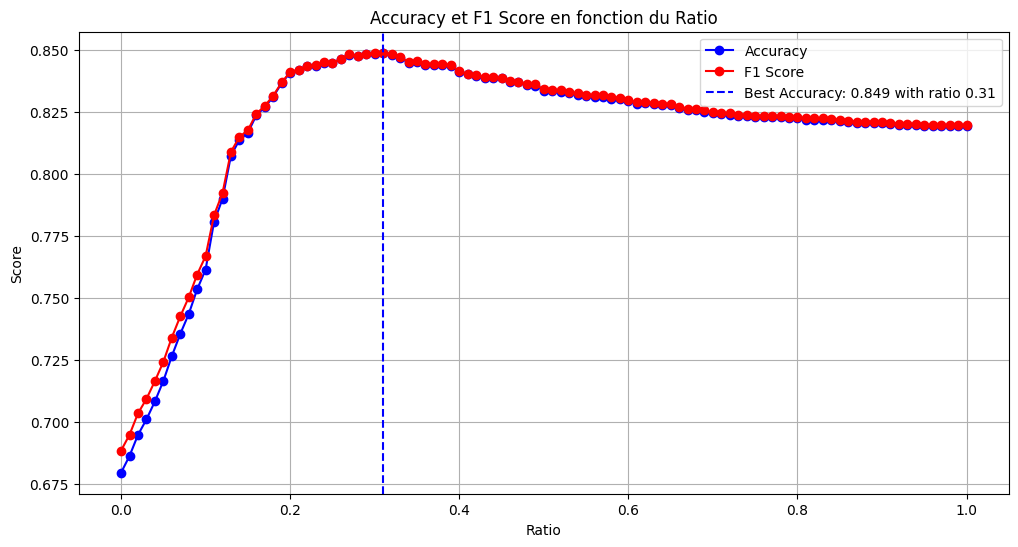

In [10]:
#plotting the accuracy and f1 score in function of the ratio
accuracy_scores = []
f1_scores = []
ratios = np.arange(0, 1.01, 0.01)

for ratio in tqdm(ratios):
    results_df['weighted_prob'] = results_df.apply(lambda row: ratio*row['cnn_proba'] + (1-ratio)*row['nlp_proba'], axis=1)
    results_df['predicted_class'] = np.argmax(np.array(results_df['weighted_prob'].tolist()), axis=1)
    accuracy = accuracy_score(df.target, results_df.predicted_class)
    f1 = f1_score(df.target, results_df.predicted_class, average='weighted')

    accuracy_scores.append(accuracy)
    f1_scores.append(f1)

plt.figure(figsize=(12, 6))
plt.plot(ratios, accuracy_scores, marker='o', linestyle='-', color='b', label='Accuracy')
plt.plot(ratios, f1_scores, marker='o', linestyle='-', color='r', label='F1 Score')
plt.axvline(best_ratio_acc, color='b', linestyle='--', label=f'Best Accuracy: {best_accuracy:.3f} with ratio {best_ratio_acc}')
plt.xlabel('Ratio')
plt.ylabel('Score')
plt.title('Accuracy et F1 Score en fonction du Ratio')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
#looping on each ratio to find the best one for each class
ratio_array = np.zeros(16)
best_accuracy = 0
best_ratio_array = np.copy(ratio_array)

for i in tqdm(range(len(ratio_array))):
    for ratio in np.arange(0, 1.01, 0.01):
        ratio_array[i] = ratio

        results_df['weighted_prob'] = results_df.apply(lambda row: ratio_array*row['cnn_proba'] + (1-ratio_array)*row['nlp_proba'], axis=1)
        results_df['predicted_class'] = np.argmax(np.array(results_df['weighted_prob'].tolist()), axis=1)
        accuracy = accuracy_score(df.target, results_df.predicted_class)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_ratio_array = np.copy(ratio_array)

    ratio_array[i] = best_ratio_array[i]

print(f'Meilleure précision: {best_accuracy}')
print(f'Meilleur tableau de ratios: {best_ratio_array}')


100%|██████████| 16/16 [01:35<00:00,  5.94s/it]

Meilleure précision: 0.8475
Meilleur tableau de ratios: [0.46 0.47 0.68 0.7  0.47 0.46 0.65 0.26 0.81 0.55 0.68 0.19 0.14 0.11
 0.13 0.34]


In [12]:
#calculating the accuracy and f1 score with the best ratio array
accuracy_scores = []
f1_scores = []


# Initialiser le tableau de ratios
ratio_array = best_ratio_array

results_df['weighted_prob'] = results_df.apply(lambda row: ratio_array*row['cnn_proba'] + (1-ratio_array)*row['nlp_proba'], axis=1)
results_df['predicted_class'] = np.argmax(np.array(results_df['weighted_prob'].tolist()), axis=1)
accuracy = accuracy_score(df.target, results_df.predicted_class)
f1 = f1_score(df.target, results_df.predicted_class, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')

Accuracy: 0.8475
F1 Score: 0.8479906673542187


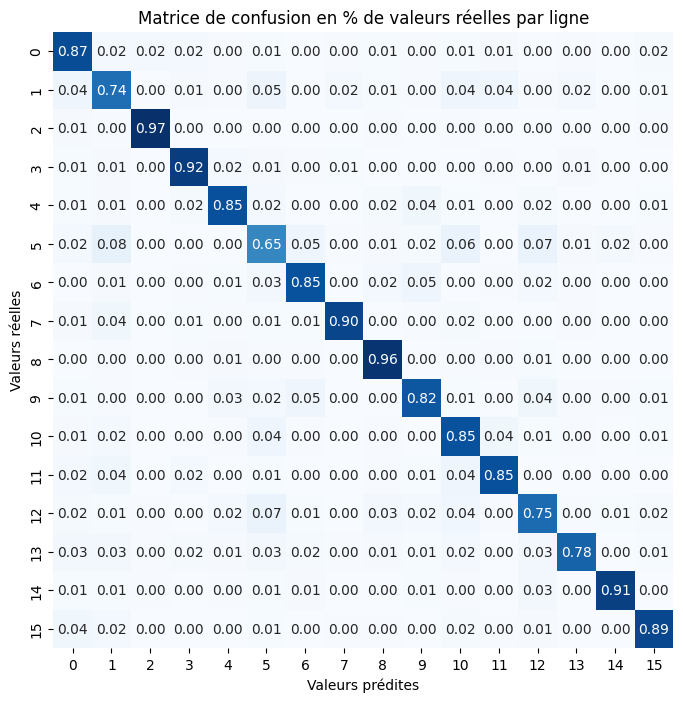

In [13]:
#ploting a confusion matrix
cm = confusion_matrix(df.target, results_df.predicted_class)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', cbar=False)
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion en % de valeurs réelles par ligne')
plt.show()